# Análise de Regressão - Olist Freight Value

## Objetivo
Prever o valor do frete (freight_value) usando diferentes modelos de regressão.

## Requisitos Obrigatórios
- ✅ Regressão Linear
- ✅ PCA para redução de dimensionalidade  
- ✅ 3 Métricas: R², MAE, RMSE

## Modelos Comparados
1. **Linear Regression** (obrigatório)
2. **Random Forest Regressor**
3. **Decision Tree Regressor**


In [53]:
# Importar bibliotecas necessárias
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import metrics

print("Bibliotecas importadas com sucesso!")


Bibliotecas importadas com sucesso!


## 1. Carregamento dos Dados

In [54]:
# Carregar datasets
order_items = pd.read_csv('data/olist_order_items_dataset.csv')
products = pd.read_csv('data/olist_products_dataset.csv')
orders = pd.read_csv('data/olist_orders_dataset.csv')
customers = pd.read_csv('data/olist_customers_dataset.csv')
sellers = pd.read_csv('data/olist_sellers_dataset.csv')
reviews = pd.read_csv('data/olist_order_reviews_dataset.csv')

print("Dados carregados:")


Dados carregados:


## 2. Features

In [55]:
# Criar feature de volume do produto
products['volume'] = (products['product_length_cm'] * 
                      products['product_height_cm'] * 
                      products['product_width_cm'])

# Preencher valores ausentes na categoria
products['product_category_name'] = products['product_category_name'].fillna('Indefinido')

print("Features criadas")

Features criadas


## 3. Merge e Preparação dos Dados

In [56]:
# Merge dos dados
data = (order_items
        .merge(products, on='product_id')
        .merge(orders, on='order_id')
        .merge(customers, on='customer_id')
        .merge(sellers, on='seller_id')
        .merge(reviews, on='order_id'))

print("Dados unidos")


Dados unidos


## 4. Criação de Features

In [57]:
# Criar feature binária: mesmo estado?
data['same_state'] = (data['customer_state'] == data['seller_state']).astype(int)

# Codificar variáveis categóricas
data['customer_state'] = data['customer_state'].astype('category').cat.codes
data['seller_state'] = data['seller_state'].astype('category').cat.codes
data['product_category'] = data['product_category_name'].astype('category').cat.codes

# Definir features para o modelo
features = [
    'volume', 
    'product_weight_g', 
    'customer_state', 
    'seller_state', 
    'same_state', 
    'product_category'
]

# Preparar X e y (removendo NaN)
X = data[features].dropna()
y = data.loc[X.index, 'freight_value']

print(f"Features criadas: {features}")
print(f"Target (Frete) - média: R$ {y.mean():.2f}")


Features criadas: ['volume', 'product_weight_g', 'customer_state', 'seller_state', 'same_state', 'product_category']
Target (Frete) - média: R$ 19.98


## 5. Train/Test Split e Normalização

In [58]:
# Dividir em treino e teste (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalizar os dados (necessário para PCA)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Divisão dos dados (20/80)")
print("Normalização aplicada com StandardScaler")

Divisão dos dados (20/80)
Normalização aplicada com StandardScaler


## 6. PCA - Redução de Dimensionalidade (Obrigatório)

In [59]:
# Aplicar PCA mantendo 95% da variância
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print("PCA aplicado:")
print(f"Dimensões originais: {X_train_scaled.shape[1]}")
print(f"Dimensões após PCA: {X_train_pca.shape[1]}")
print(f"\nComponentes principais mantidos: {len(pca.explained_variance_ratio_)}")
print(f"Features originais: {features}")


PCA aplicado:
Dimensões originais: 6
Dimensões após PCA: 5

Componentes principais mantidos: 5
Features originais: ['volume', 'product_weight_g', 'customer_state', 'seller_state', 'same_state', 'product_category']


## 7. Definição dos Modelos de Regressão

In [60]:
# Definir os 3 modelos para comparação
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(
        n_estimators=100, 
        max_depth=15, 
        min_samples_leaf=2, 
        max_features='sqrt', 
        random_state=42, 
        n_jobs=-1
    ),
    'Decision Tree': DecisionTreeRegressor(
        max_depth=15, 
        min_samples_leaf=2, 
        ccp_alpha=0.0, 
        random_state=42
    )
}

print("Modelos definidos:")
for i, model_name in enumerate(models.keys(), 1):
    print(f"   {i}. {model_name}")


Modelos definidos:
   1. Linear Regression
   2. Random Forest
   3. Decision Tree


## 8. Treinamento e Avaliação dos Modelos

In [61]:
# Dicionário para armazenar resultados
results = {}

# Treinar e avaliar cada modelo
for model_name, model in models.items():
    print(f"{'='*60}")
    print(f"Modelo: {model_name}")
    print(f"{'='*60}")
    
    # Treinar modelo
    model.fit(X_train_pca, y_train)
    
    # Predições
    y_pred = model.predict(X_test_pca)
    
    # Calcular as 3 métricas obrigatórias
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred) ** 0.5
    
    # Calcular acurácia com tolerância
    tolerance = 0.2  # 20% de tolerância
    accuracy = (abs(y_test - y_pred) / y_test <= tolerance).mean() * 100
    
    # Armazenar resultados
    results[model_name] = {
        'R²': r2,
        'MAE': mae,
        'RMSE': rmse,
        'Acurácia (±20%)': accuracy
    }
    
    # Exibir métricas
    print(f"R² Score: {r2:.4f}")
    print(f"MAE (Mean Absolute Error): R$ {mae:.2f}")
    print(f"RMSE (Root Mean Squared Error): R$ {rmse:.2f}")
    print(f"Predições dentro de ±20%: {accuracy:.2f}%")
    print()

print("Todos os modelos foram treinados e avaliados!")


Modelo: Linear Regression
R² Score: 0.5225
MAE (Mean Absolute Error): R$ 5.96
RMSE (Root Mean Squared Error): R$ 10.98
Predições dentro de ±20%: 49.25%

Modelo: Random Forest
R² Score: 0.7177
MAE (Mean Absolute Error): R$ 4.20
RMSE (Root Mean Squared Error): R$ 8.45
Predições dentro de ±20%: 68.43%

Modelo: Decision Tree
R² Score: 0.6112
MAE (Mean Absolute Error): R$ 4.59
RMSE (Root Mean Squared Error): R$ 9.91
Predições dentro de ±20%: 67.31%

Todos os modelos foram treinados e avaliados!


## 9. Comparação dos Modelos

In [62]:
# Tabela comparativa dos modelos
print(f"{'='*70}")
print("COMPARAÇÃO DOS MODELOS")
print(f"{'='*70}")
print(f"{'Modelo':<25} {'R²':<10} {'MAE':<12} {'RMSE':<12} {'Acurácia':<10}")
print(f"{'-'*70}")

for model_name, metrics in results.items():
    print(f"{model_name:<25} {metrics['R²']:<10.4f} R$ {metrics['MAE']:<9.2f} R$ {metrics['RMSE']:<9.2f} {metrics['Acurácia (±20%)']:<9.2f}%")

# Identificar o melhor modelo baseado em R²
best_model = max(results.items(), key=lambda x: x[1]['R²'])
print(f"\n{'='*70}")
print(f"Melhor modelo (por R²): {best_model[0]}")
print(f"   - R² Score: {best_model[1]['R²']:.4f}")
print(f"   - MAE: R$ {best_model[1]['MAE']:.2f}")
print(f"   - RMSE: R$ {best_model[1]['RMSE']:.2f}")
print(f"   - Acurácia (±20%): {best_model[1]['Acurácia (±20%)']:.2f}%")
print(f"{'='*70}")


COMPARAÇÃO DOS MODELOS
Modelo                    R²         MAE          RMSE         Acurácia  
----------------------------------------------------------------------
Linear Regression         0.5225     R$ 5.96      R$ 10.98     49.25    %
Random Forest             0.7177     R$ 4.20      R$ 8.45      68.43    %
Decision Tree             0.6112     R$ 4.59      R$ 9.91      67.31    %

Melhor modelo (por R²): Random Forest
   - R² Score: 0.7177
   - MAE: R$ 4.20
   - RMSE: R$ 8.45
   - Acurácia (±20%): 68.43%


## 9.1. Visualização das Métricas

C:\Users\lnata\AppData\Local\Temp\ipykernel_9224\4252528563.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(model_names, rotation=15, ha='right')
C:\Users\lnata\AppData\Local\Temp\ipykernel_9224\4252528563.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(model_names, rotation=15, ha='right')
C:\Users\lnata\AppData\Local\Temp\ipykernel_9224\4252528563.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(model_names, rotation=15, ha='right')


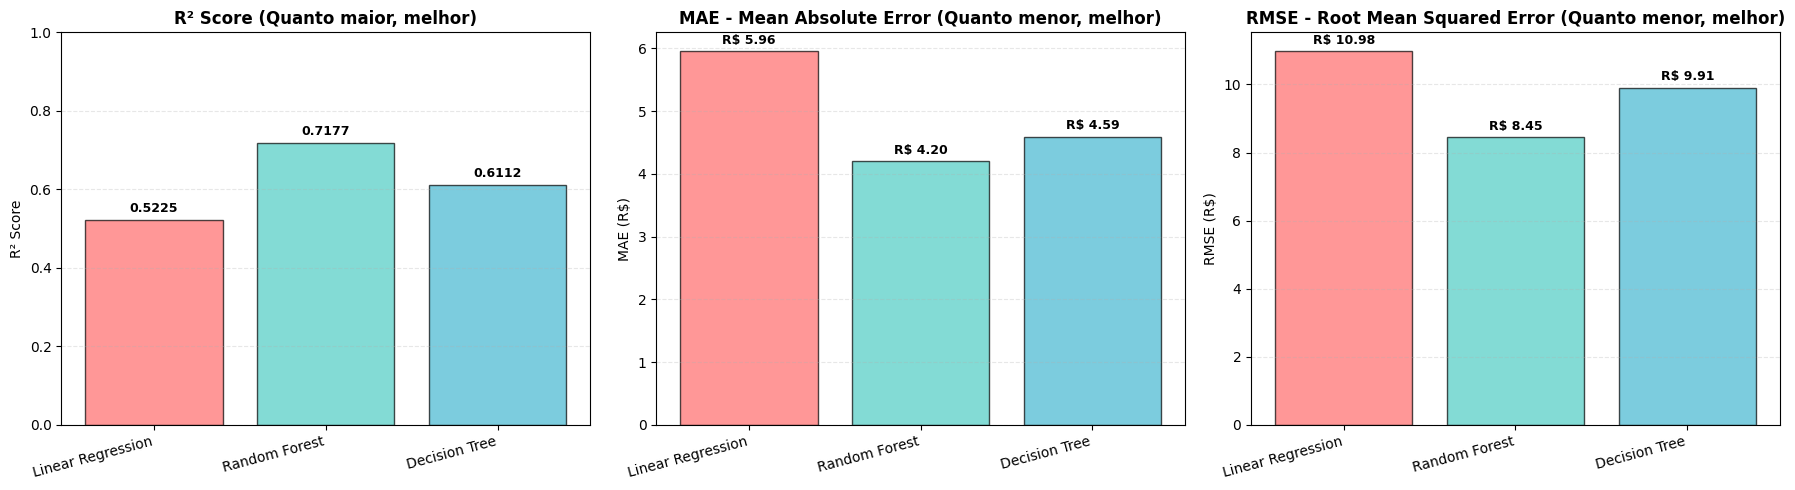

Gráficos de métricas gerados!


In [63]:
import matplotlib.pyplot as plt

# Preparar dados para visualização
model_names = list(results.keys())
r2_scores = [results[m]['R²'] for m in model_names]
mae_scores = [results[m]['MAE'] for m in model_names]
rmse_scores = [results[m]['RMSE'] for m in model_names]

# Criar figura com 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Cores para cada modelo
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

# 1. R² Score
axes[0].bar(model_names, r2_scores, color=colors, alpha=0.7, edgecolor='black')
axes[0].set_title('R² Score (Quanto maior, melhor)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('R² Score', fontsize=10)
axes[0].set_ylim([0, 1])
axes[0].grid(axis='y', alpha=0.3, linestyle='--')
for i, v in enumerate(r2_scores):
    axes[0].text(i, v + 0.02, f'{v:.4f}', ha='center', fontsize=9, fontweight='bold')

# 2. MAE (Mean Absolute Error)
axes[1].bar(model_names, mae_scores, color=colors, alpha=0.7, edgecolor='black')
axes[1].set_title('MAE - Mean Absolute Error (Quanto menor, melhor)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('MAE (R$)', fontsize=10)
axes[1].grid(axis='y', alpha=0.3, linestyle='--')
for i, v in enumerate(mae_scores):
    axes[1].text(i, v + max(mae_scores)*0.02, f'R$ {v:.2f}', ha='center', fontsize=9, fontweight='bold')

# 3. RMSE (Root Mean Squared Error)
axes[2].bar(model_names, rmse_scores, color=colors, alpha=0.7, edgecolor='black')
axes[2].set_title('RMSE - Root Mean Squared Error (Quanto menor, melhor)', fontsize=12, fontweight='bold')
axes[2].set_ylabel('RMSE (R$)', fontsize=10)
axes[2].grid(axis='y', alpha=0.3, linestyle='--')
for i, v in enumerate(rmse_scores):
    axes[2].text(i, v + max(rmse_scores)*0.02, f'R$ {v:.2f}', ha='center', fontsize=9, fontweight='bold')

# Rotacionar labels do eixo X
for ax in axes:
    ax.set_xticklabels(model_names, rotation=15, ha='right')

plt.tight_layout()
plt.show()

print("Gráficos de métricas gerados!")

## 9.2. Curvas de Aprendizado

Gerando curva de aprendizado para Linear Regression...
Gerando curva de aprendizado para Random Forest...
Gerando curva de aprendizado para Decision Tree...


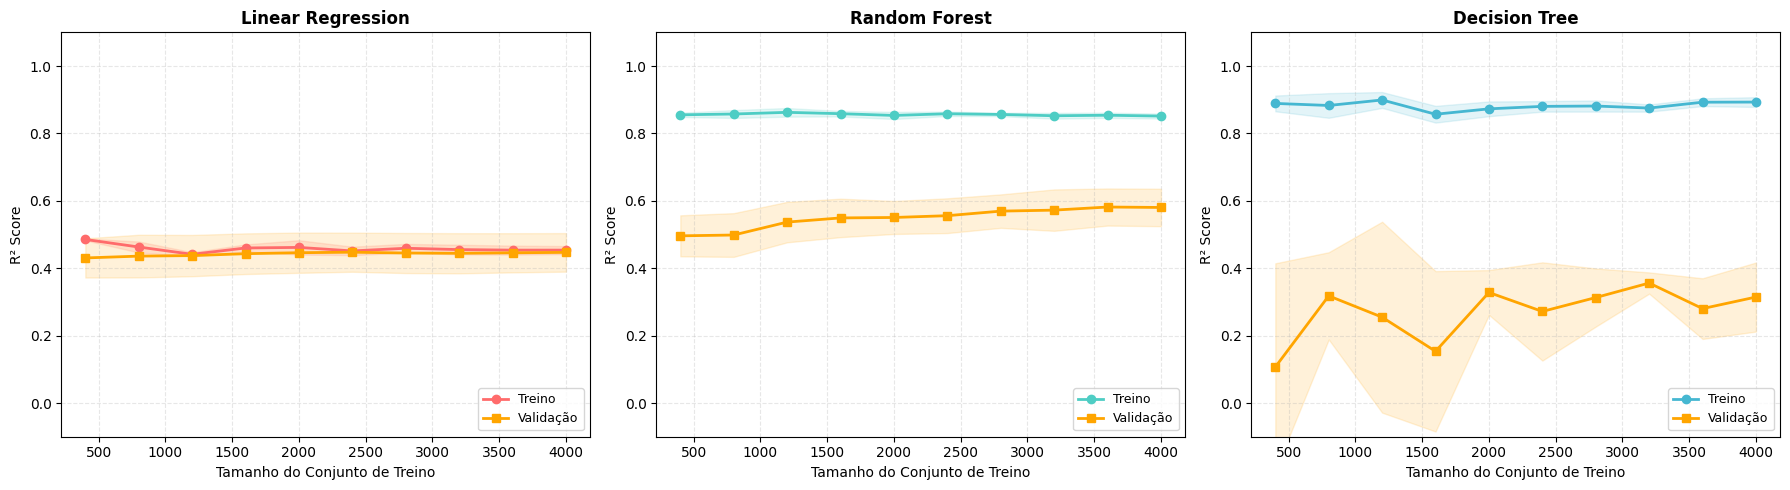


Curvas de aprendizado geradas!


In [64]:
from sklearn.model_selection import learning_curve

# Configurar figura para curvas de aprendizado
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Cores para cada modelo
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

# Gerar curvas de aprendizado para cada modelo
for idx, (model_name, model) in enumerate(models.items()):
    ax = axes[idx]
    
    print(f"Gerando curva de aprendizado para {model_name}...")
    
    # Calcular curva de aprendizado
    # Usar amostra menor para acelerar o processo
    sample_size = min(5000, len(X_train_pca))
    sample_indices = np.random.choice(len(X_train_pca), size=sample_size, replace=False)
    X_sample = X_train_pca[sample_indices]
    y_sample = y_train.iloc[sample_indices]
    
    train_sizes, train_scores, val_scores = learning_curve(
        model, 
        X_sample, 
        y_sample,
        cv=5,  # 5-fold cross-validation
        train_sizes=np.linspace(0.1, 1.0, 10),
        scoring='r2',
        n_jobs=-1,
        random_state=42
    )
    
    # Calcular médias e desvios padrão
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)
    
    # Plotar curvas
    ax.plot(train_sizes, train_mean, 'o-', color=colors[idx], label='Treino', linewidth=2, markersize=6)
    ax.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.15, color=colors[idx])
    
    ax.plot(train_sizes, val_mean, 's-', color='orange', label='Validação', linewidth=2, markersize=6)
    ax.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.15, color='orange')
    
    # Configurar subplot
    ax.set_title(f'{model_name}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Tamanho do Conjunto de Treino', fontsize=10)
    ax.set_ylabel('R² Score', fontsize=10)
    ax.legend(loc='lower right', fontsize=9)
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.set_ylim([-0.1, 1.1])

plt.tight_layout()
plt.show()

print("\nCurvas de aprendizado geradas!")

10. Features

In [65]:
# Criar feature de volume do produto
data['time_to_deliver'] = (pd.to_datetime(data['order_delivered_customer_date']) - pd.to_datetime(data['order_purchase_timestamp'])).dt.days

print("Features criadas")

Features criadas


11. Criação das Features

In [66]:
# Definir features para o modelo
features = [
    'price',
    'freight_value',
    'time_to_deliver'
]

# Preparar X e y (removendo NaN)
X = data[features].dropna()
y = data.loc[X.index, 'review_score']

print(f"Features criadas: {features}")
print(f"Target (Review Score) - média: {y.mean():.2f}")

Features criadas: ['price', 'freight_value', 'time_to_deliver']
Target (Review Score) - média: 4.08


12. Train Test Split

In [67]:
# Dividir em treino e teste (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalizar os dados (necessário para PCA)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Divisão dos dados (20/80)")
print("Normalização aplicada com StandardScaler")

Divisão dos dados (20/80)
Normalização aplicada com StandardScaler


13. PCA - Redução de Dimensionalidade (Obrigatório)

In [68]:
# Aplicar PCA mantendo 95% da variância
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print("PCA aplicado:")
print(f"Dimensões originais: {X_train_scaled.shape[1]}")
print(f"Dimensões após PCA: {X_train_pca.shape[1]}")
print(f"\nComponentes principais mantidos: {len(pca.explained_variance_ratio_)}")
print(f"Features originais: {features}")


PCA aplicado:
Dimensões originais: 3
Dimensões após PCA: 3

Componentes principais mantidos: 3
Features originais: ['price', 'freight_value', 'time_to_deliver']


14. Definição dos Modelos de Detecção de Anomalias

In [ ]:
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM

# Definir os 3 modelos de detecção de anomalias
models = {
    'Isolation Forest': IsolationForest(
        contamination=0.01,  # 1% dos dados são considerados anomalias
        n_jobs=-1
    ),
    'Local Outlier Factor': LocalOutlierFactor(
        contamination=0.01,
        novelty=False,  # Modo de detecção em dados de treino
        n_jobs=-1
    ),
    'One-Class SVM': OneClassSVM(
        nu=0.01,  # Proporção de outliers esperada
        kernel='rbf',
        gamma='auto'
    )
}

print("Modelos de Detecção de Anomalias definidos:")
for i, model_name in enumerate(models.keys(), 1):
    print(f"   {i}. {model_name}")

Modelos de Detecção de Anomalias definidos:
   1. Isolation Forest
   2. Local Outlier Factor
   3. One-Class SVM


15. Treinamento e Avaliação dos Modelos de Detecção de Anomalias

In [70]:
from collections import Counter

# Treinar e avaliar modelos de detecção de anomalias
# Usando amostra de 10.000 pontos para reduzir tempo e memória
sample_size = 10000
np.random.seed(42)
sample_indices = np.random.choice(len(X_train_pca), size=min(sample_size, len(X_train_pca)), replace=False)
X_train_sample = X_train_pca[sample_indices]

anomaly_results = {}

for model_name, model in models.items():
    print(f"{'='*60}")
    print(f"Modelo: {model_name}")
    print(f"{'='*60}")
    
    # Treinar e obter predições (-1 = anomalia, 1 = normal)
    if model_name == 'Local Outlier Factor':
        # LOF tem comportamento diferente - não tem método predict separado
        predictions = model.fit_predict(X_train_sample)
    else:
        model.fit(X_train_sample)
        predictions = model.predict(X_train_sample)
    
    # Contar anomalias e normais
    label_counts = dict(Counter(predictions))
    n_anomalies = int(label_counts.get(-1, 0))
    n_normal = int(label_counts.get(1, 0))
    anomaly_percentage = (n_anomalies / len(predictions)) * 100
    
    # Obter scores de anomalia (quando disponível)
    anomaly_scores = None
    if hasattr(model, 'decision_function'):
        try:
            anomaly_scores = model.decision_function(X_train_sample)
            mean_score = float(np.mean(anomaly_scores))
            std_score = float(np.std(anomaly_scores))
        except:
            mean_score = None
            std_score = None
    else:
        mean_score = None
        std_score = None
    
    # Armazenar resultados
    anomaly_results[model_name] = {
        'n_anomalies': n_anomalies,
        'n_normal': n_normal,
        'anomaly_percentage': anomaly_percentage,
        'mean_anomaly_score': mean_score,
        'std_anomaly_score': std_score,
        'predictions_sample': predictions[:10].tolist()
    }
    
    # Exibir métricas resumidas
    print(f"Anomalias detectadas: {n_anomalies} ({anomaly_percentage:.2f}%)")
    print(f"Dados normais: {n_normal} ({100-anomaly_percentage:.2f}%)")
    if mean_score is not None:
        print(f"Score médio de anomalia: {mean_score:.4f} (±{std_score:.4f})")
    print()

print(f"Avaliação de detecção de anomalias concluída (amostra de {len(X_train_sample):,} pontos).")
# resultados disponíveis em `anomaly_results`

Modelo: Isolation Forest
Anomalias detectadas: 100 (1.00%)
Dados normais: 9900 (99.00%)
Score médio de anomalia: 0.2997 (±0.0762)

Modelo: Local Outlier Factor
Anomalias detectadas: 100 (1.00%)
Dados normais: 9900 (99.00%)

Modelo: One-Class SVM
Anomalias detectadas: 105 (1.05%)
Dados normais: 9895 (98.95%)
Score médio de anomalia: 0.3061 (±0.1523)

Avaliação de detecção de anomalias concluída (amostra de 10,000 pontos).


## 16. Visualização das Anomalias

Processando Isolation Forest...
Processando Local Outlier Factor...


c:\Users\lnata\Projects\olist-ai-modelling\venv\Lib\site-packages\sklearn\neighbors\_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(


Processando One-Class SVM...


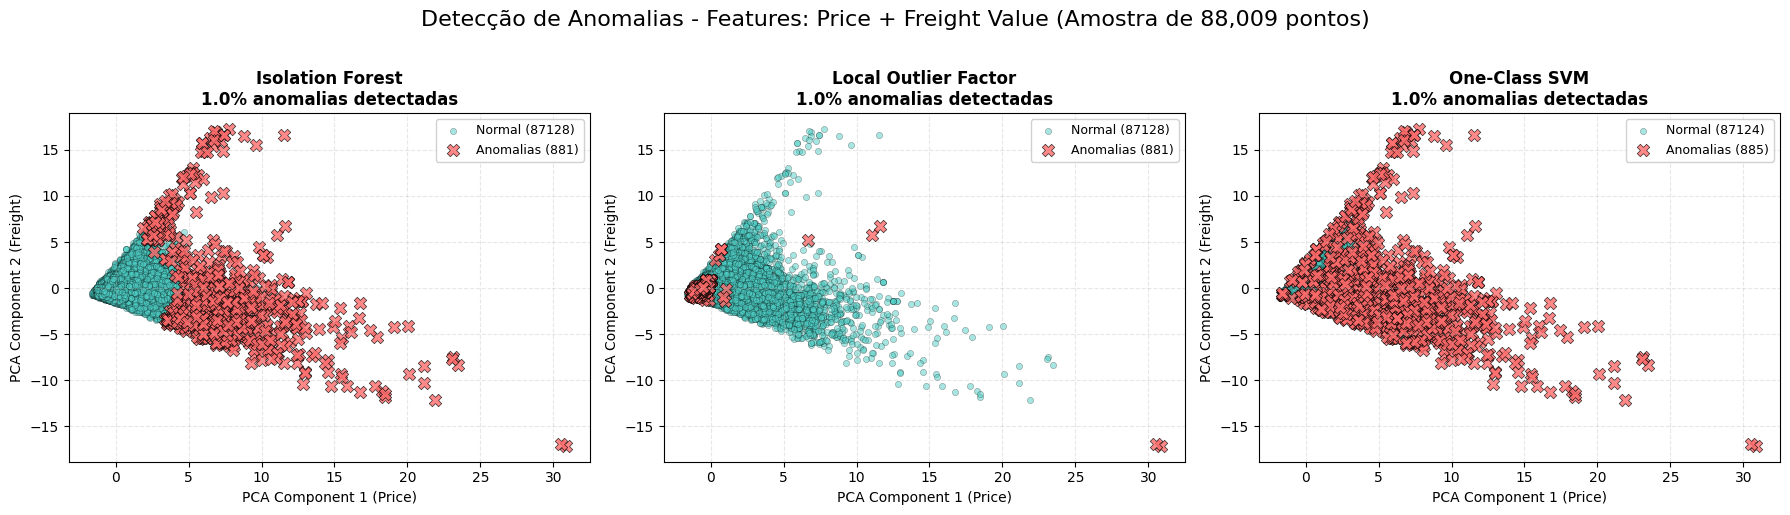


Visualizações de anomalias geradas para todos os modelos


In [71]:
import matplotlib.pyplot as plt

# Criar amostra para visualização
# sample_size = 10000
# np.random.seed(42)
# sample_indices = np.random.choice(len(X_train_pca), size=min(sample_size, len(X_train_pca)), replace=False)
X_sample = X_train_pca#[sample_indices]

# Configurar figura com subplots para os modelos
n_models = len(models)
fig, axes = plt.subplots(1, n_models, figsize=(6*n_models, 5))
if n_models == 1:
    axes = [axes]
fig.suptitle(f'Detecção de Anomalias - Features: Price + Freight Value (Amostra de {len(X_sample):,} pontos)', fontsize=16, y=1.02)

for idx, (model_name, model) in enumerate(models.items()):
    ax = axes[idx]
    
    print(f"Processando {model_name}...")
    
    # Obter predições de anomalias
    if model_name == 'Local Outlier Factor':
        predictions = model.fit_predict(X_sample)
    else:
        model.fit(X_sample)
        predictions = model.predict(X_sample)
    
    # Separar dados normais e anomalias
    normal_mask = predictions == 1
    anomaly_mask = predictions == -1
    
    n_anomalies = np.sum(anomaly_mask)
    anomaly_pct = (n_anomalies / len(predictions)) * 100
    
    # Plotar dados normais
    ax.scatter(
        X_sample[normal_mask, 0], 
        X_sample[normal_mask, 1] if X_sample.shape[1] > 1 else X_sample[normal_mask, 0],
        c='#4ECDC4',
        label=f'Normal ({np.sum(normal_mask)})',
        alpha=0.5,
        edgecolors='black',
        linewidth=0.3,
        marker='o',
        s=20
    )
    
    # Plotar anomalias
    ax.scatter(
        X_sample[anomaly_mask, 0], 
        X_sample[anomaly_mask, 1] if X_sample.shape[1] > 1 else X_sample[anomaly_mask, 0],
        c='#FF6B6B',
        label=f'Anomalias ({n_anomalies})',
        alpha=0.8,
        edgecolors='black',
        linewidth=0.5,
        marker='X',
        s=80
    )
    
    # Configurar subplot
    ax.set_title(f'{model_name}\n{anomaly_pct:.1f}% anomalias detectadas', fontsize=12, fontweight='bold')
    ax.set_xlabel('PCA Component 1 (Price)', fontsize=10)
    ax.set_ylabel('PCA Component 2 (Freight)' if X_sample.shape[1] > 1 else 'PCA Component 1', fontsize=10)
    ax.legend(loc='upper right', fontsize=9, framealpha=0.9)
    ax.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

print("\nVisualizações de anomalias geradas para todos os modelos")

## 17. Comparação dos Modelos de Detecção de Anomalias

COMPARAÇÃO DOS MODELOS DE DETECÇÃO DE ANOMALIAS
Modelo                         Anomalias       Normal          % Anomalias    
--------------------------------------------------------------------------------
Isolation Forest               100             9900            1.00          %
Local Outlier Factor           100             9900            1.00          %
One-Class SVM                  105             9895            1.05          %


C:\Users\lnata\AppData\Local\Temp\ipykernel_9224\1062214942.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(model_names, rotation=15, ha='right')


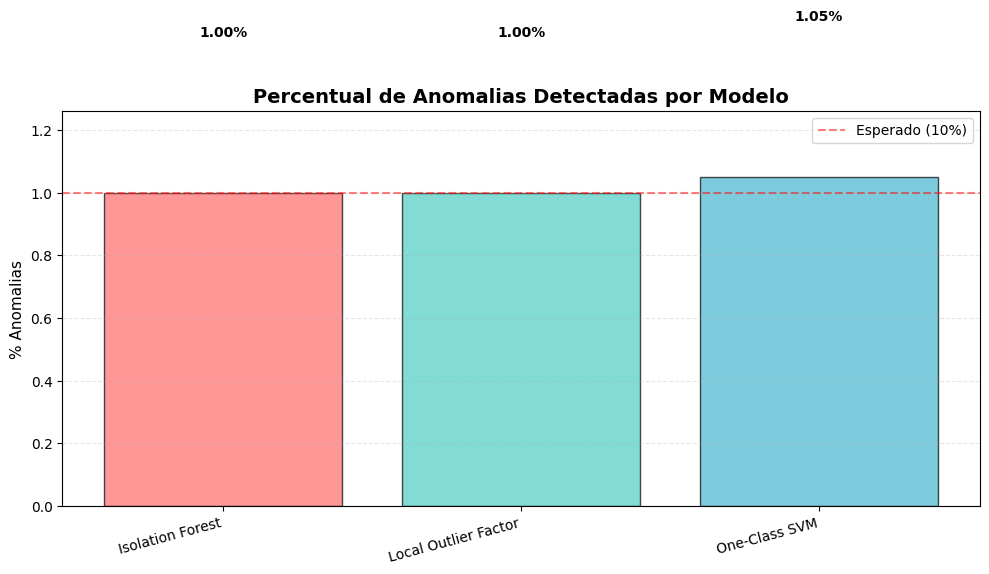


Comparação concluída!


In [72]:
# Tabela comparativa dos modelos de detecção de anomalias
print(f"{'='*80}")
print("COMPARAÇÃO DOS MODELOS DE DETECÇÃO DE ANOMALIAS")
print(f"{'='*80}")
print(f"{'Modelo':<30} {'Anomalias':<15} {'Normal':<15} {'% Anomalias':<15}")
print(f"{'-'*80}")

for model_name, metrics in anomaly_results.items():
    print(f"{model_name:<30} {metrics['n_anomalies']:<15} {metrics['n_normal']:<15} {metrics['anomaly_percentage']:<14.2f}%")

print(f"{'='*80}")

# Gráfico de barras comparando % de anomalias detectadas
fig, ax = plt.subplots(figsize=(10, 6))

model_names = list(anomaly_results.keys())
anomaly_percentages = [anomaly_results[m]['anomaly_percentage'] for m in model_names]

colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
bars = ax.bar(model_names, anomaly_percentages, color=colors, alpha=0.7, edgecolor='black')

ax.set_title('Percentual de Anomalias Detectadas por Modelo', fontsize=14, fontweight='bold')
ax.set_ylabel('% Anomalias', fontsize=11)
ax.set_ylim([0, max(anomaly_percentages) * 1.2])
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.axhline(y=1, color='red', linestyle='--', linewidth=1.5, alpha=0.5, label='Esperado (10%)')

# Adicionar valores nas barras
for i, (bar, v) in enumerate(zip(bars, anomaly_percentages)):
    ax.text(bar.get_x() + bar.get_width()/2, v + 0.5, f'{v:.2f}%', 
            ha='center', fontsize=10, fontweight='bold')

ax.set_xticklabels(model_names, rotation=15, ha='right')
ax.legend()

plt.tight_layout()
plt.show()

print("\nComparação concluída!")

## 18. Curva de Aprendizado - Detecção de Anomalias

Gerando curva de aprendizado para Isolation Forest...
Gerando curva de aprendizado para Local Outlier Factor...
Gerando curva de aprendizado para Local Outlier Factor...
Gerando curva de aprendizado para One-Class SVM...
Gerando curva de aprendizado para One-Class SVM...


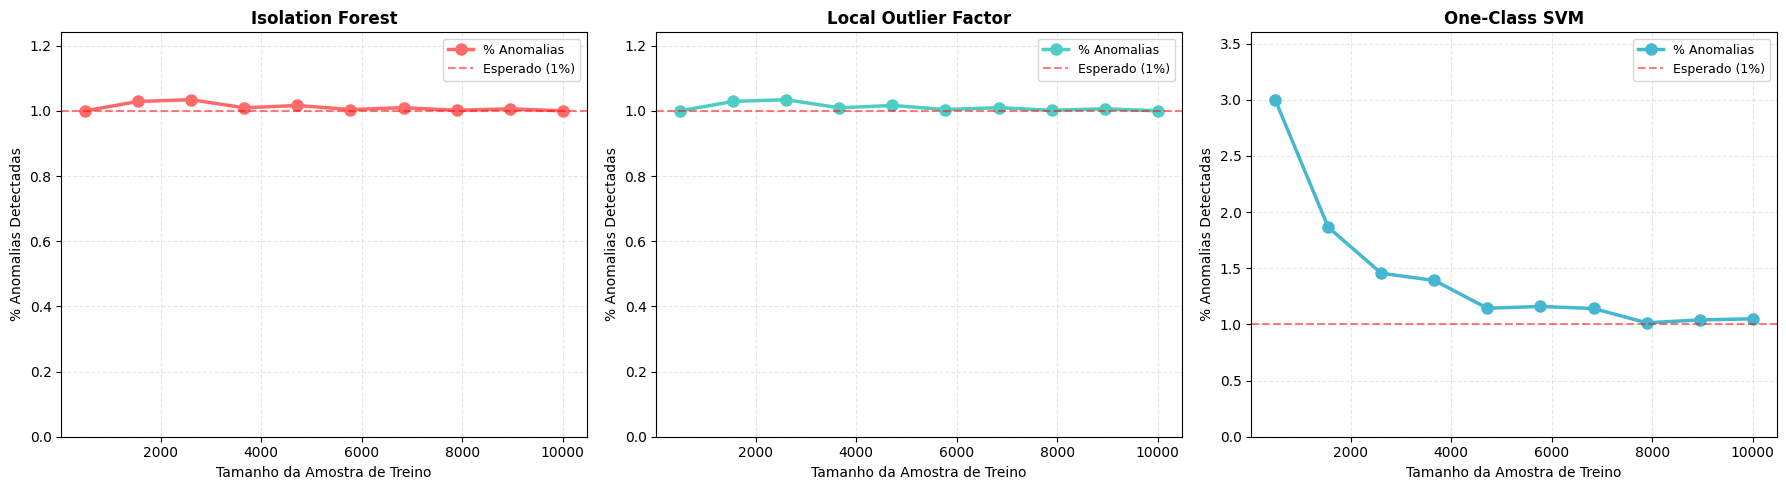


Curvas de aprendizado geradas para modelos de detecção de anomalias!


In [73]:
import matplotlib.pyplot as plt

# Configurar figura para curvas de aprendizado dos modelos não supervisionados
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Cores para cada modelo
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

# Tamanhos de amostra para avaliar
train_sizes = np.linspace(500, 10000, 10).astype(int)

for idx, (model_name, model_class) in enumerate(models.items()):
    ax = axes[idx]
    
    print(f"Gerando curva de aprendizado para {model_name}...")
    
    anomaly_percentages = []
    consistency_scores = []
    
    for size in train_sizes:
        # Criar amostra de treino
        np.random.seed(42)
        sample_indices = np.random.choice(len(X_train_pca), size=min(size, len(X_train_pca)), replace=False)
        X_sample = X_train_pca[sample_indices]
        
        # Recriar o modelo para cada tamanho
        if model_name == 'Isolation Forest':
            model = IsolationForest(contamination=0.01, random_state=42, n_jobs=-1)
        elif model_name == 'Local Outlier Factor':
            model = LocalOutlierFactor(contamination=0.01, novelty=False, n_jobs=-1)
        else:  # One-Class SVM
            model = OneClassSVM(nu=0.01, kernel='rbf', gamma='auto')
        
        # Treinar e predizer
        if model_name == 'Local Outlier Factor':
            predictions = model.fit_predict(X_sample)
        else:
            model.fit(X_sample)
            predictions = model.predict(X_sample)
        
        # Calcular métricas
        n_anomalies = np.sum(predictions == -1)
        anomaly_pct = (n_anomalies / len(predictions)) * 100
        anomaly_percentages.append(anomaly_pct)
        
        # Score de consistência (quanto mais próximo de 1%, mais consistente)
        consistency = 1.0 - abs(anomaly_pct - 1.0) / 10.0  # normalizado
        consistency_scores.append(max(0, consistency))
    
    # Plotar curva de percentual de anomalias
    ax.plot(train_sizes, anomaly_percentages, 'o-', color=colors[idx], 
            label='% Anomalias', linewidth=2.5, markersize=8)
    
    # Linha de referência (1% esperado)
    ax.axhline(y=1.0, color='red', linestyle='--', linewidth=1.5, alpha=0.5, label='Esperado (1%)')
    
    # Configurar subplot
    ax.set_title(f'{model_name}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Tamanho da Amostra de Treino', fontsize=10)
    ax.set_ylabel('% Anomalias Detectadas', fontsize=10)
    ax.legend(loc='best', fontsize=9)
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.set_ylim([0, max(anomaly_percentages) * 1.2])

plt.tight_layout()
plt.show()

print("\nCurvas de aprendizado geradas para modelos de detecção de anomalias!")